# Problem Set 7

<span style="color:red">Warning!</span> Some of the problems in this problem set require heavy computation - you are encouraged to start early so that you don't get stuck at the last minute.

# Face Recognition

Your goal for this problem set is to design a basic face recognition system. Since the machine learning force is now strong with you, the prompts for this problem set are deliberately vague. Be creative - but be careful! It my be useful to start by implementing this entire problem set on a relatively small subset of all of the images first, before using the full dataset.

## 1. Data Preprocessing and  Exploration

Download the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)" data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

### 1.1. Filter out people with few images

First, display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images from your dataset? 

Now, remove all individuals for whom you have fewer than 10 images. How many individuals are you left with in the dataset?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from skimage import data
from skimage import io
import warnings
warnings.filterwarnings('ignore')

/Users/zhouyi/opt/anaconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [3]:
directory = '/Users/zhouyi/Desktop/Info251/PS7/lfw_funneled'
names = [name for name in os.listdir(directory)]

n_images = np.zeros(len(names))
for i in range(len(names)):
    req_dir = directory + '/' + names[i]
    n_images[i] = len([name for name in os.listdir(req_dir)])
    
n_images_df = pd.DataFrame({'Name':names, 'ImageCount':n_images})
n_images_df.sort_values('ImageCount',ascending=False)

,Name,ImageCount
4982,George_W_Bush,530.0
3541,Colin_Powell,236.0
1554,Tony_Blair,144.0
3014,Donald_Rumsfeld,121.0
1392,Gerhard_Schroeder,109.0
...,...,...
2243,Paul_Walker,1.0
2241,Ewan_McGregor,1.0
2240,James_Brazelton,1.0
2233,Ed_Book,1.0


Text(0.5, 0, 'Number of Images')

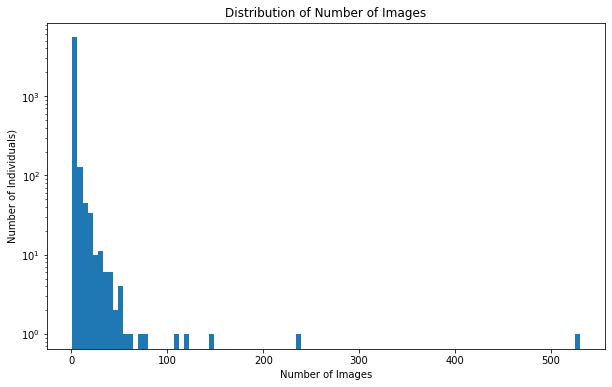

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(n_images_df['ImageCount'], bins=100, log=True)
plt.title("Distribution of Number of Images")
plt.ylabel("Number of Individuals)")
plt.xlabel("Number of Images")

In [5]:
req_images_df = n_images_df[n_images_df['ImageCount'] >= 10]
req_images_df.reset_index(drop=True,inplace=True)
req_images_df

,Name,ImageCount
0,Salma_Hayek,13.0
1,Queen_Elizabeth_II,13.0
2,Jennifer_Aniston,21.0
3,Jacques_Rogge,10.0
4,Andy_Roddick,15.0
...,...,...
153,Trent_Lott,16.0
154,Lleyton_Hewitt,41.0
155,John_Ashcroft,53.0
156,Dominique_de_Villepin,15.0


George_W_Bush has the most number of images. And after removing all individuals for whom you have fewer than 10 images. I have 158 individuals left

### 1.2. Show some faces!

1. Pick 10 random images from the dataset and display them in a 2 x 5 grid.
2. This time pick 200 random images. Create a single image that shows the "average face" over this random sample -- i.e. each pixel should display the average value of that particular pixel across the random sample. 

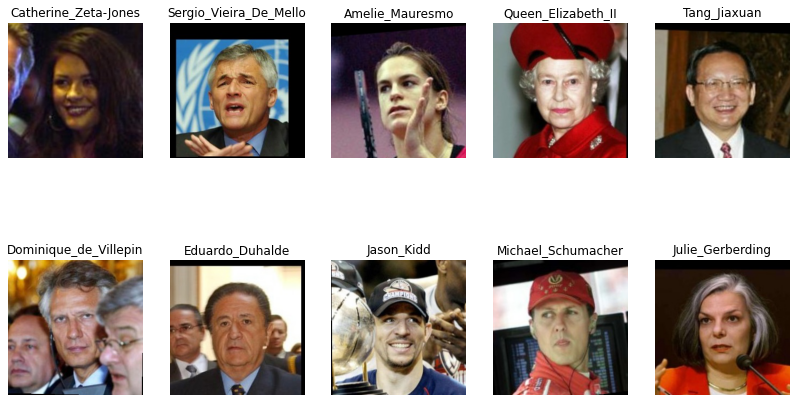

In [6]:
random_images = np.random.choice(req_images_df['Name'], size=10, replace=False)

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(14, 8))

ax = ax.flatten()

for i in range(len(random_images)):
    req_dir = directory + '/' + random_images[i]
    images = [name for name in os.listdir(req_dir)]
    image = np.random.choice(images, size=1, replace=False)
    image = image[0]
    image_path = req_dir + '/' + image
    ax[i].imshow(plt.imread(image_path))
    ax[i].set_title(random_images[i])
    ax[i].axis('off')

In [7]:
random_images = np.random.choice(req_images_df['Name'], size=200)

image_data = []
for i in range(len(random_images)):
    person = random_images[i]
    req_dir = directory + '/' + person
    images = [name for name in os.listdir(req_dir)]
    for image in images:
        image_data.append(io.imread(os.path.join(req_dir, image)))

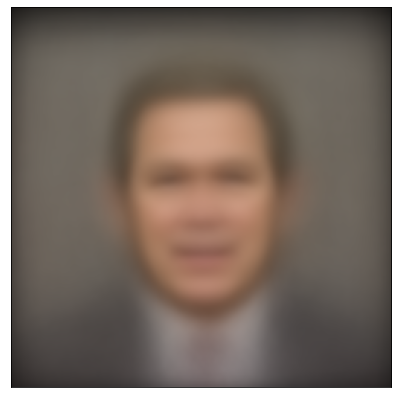

In [8]:
avg_face = np.mean(image_data,axis=0)
avg_face = avg_face/255

# Plot
fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(avg_face)
ax.set_xticks([])
ax.set_yticks([])

plt.show(fig)

## 2. k-Means Clustering


### 2.1. Implementation

Implement the k-Means clustering algorithm that we discussed in class, using the Euclidean distance function. This will require that you define three new functions:
1. InitializeCentroids(X, k)
2. FindClosestCentroids(X, centroids)
3. ComputeCentroidMeans(X, centroids, k)

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful.

In [9]:
from sklearn.metrics import pairwise_distances_argmin

def InitializeCentroids(X, k):
    rows = np.random.choice(np.shape(X)[0], k, replace=False)
    centroids = X[rows].copy()
    return centroids

def FindClosestCentroids(X, centroids):
    idx = pairwise_distances_argmin(X, centroids, metric='euclidean')
    return idx

def ComputeCentroidMeans(X, centroids,idx, k):
    new_centroids = np.zeros(np.shape(centroids))
    for i in range(k):
        this_X = X[idx==i]
        new_centroids[i] = np.mean(this_X, axis=0)       
    return new_centroids


def ClusterKM(X, k):
    centroids = InitializeCentroids(X,k)
    
    while True:
        idx = FindClosestCentroids(X, centroids)
        new_centroids = ComputeCentroidMeans(X, centroids,idx, k)

        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return centroids, idx

### 2.2. Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. Also create a scatterplot that shows these datapoints, colored by cluster. 

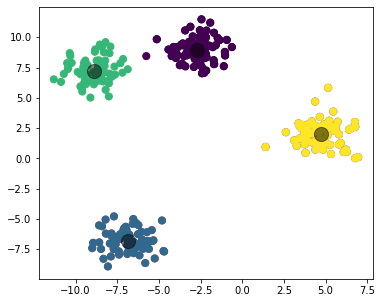

In [10]:
from sklearn.datasets import make_blobs

x, y = make_blobs(n_samples=300, n_features=2, centers=4, cluster_std=1, random_state=42)

# Plot synthetic data
fig, ax = plt.subplots(1, figsize=(6, 5))
ax.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='magma')

myCenters, myIdx = ClusterKM(x, 4)

ax.scatter(x[:, 0], x[:, 1], c=myIdx, s=50, cmap='viridis')
ax.scatter(myCenters[:, 0], myCenters[:, 1], c='black', s=200, alpha=0.5)

### 2.3. Image centroids
Apply your k-Means algorithm to the images dataset, using k=10. Make sure to standardize your data first! Show a 10 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250x250x3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- and even if it is -- it might take a long time for your algorithm to converge. If your computer is slow, it might even take a very long time for you to simply standardize your data. We recommend you convert your RGB images into grayscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function, or any other way to convert to graysacle) before standardizing.



In [20]:
from PIL import Image

all_imgs = {}
for person in req_images_df['Name']:
    all_imgs[person] = [img for img in os.listdir("lfw_funneled/"+person)]

all_data = []

for key, value in all_imgs.items():
    for img in value:
        image = Image.open('lfw_funneled/'+key+'/'+img) # read images from folders
        data = np.array(image) # convert to array shape of (250,250,3)
        all_data.append(data) # append data to list

In [22]:
df = pd.DataFrame()
df['Pictures'] = all_data

def normalizeImage(image):
    image = image.astype('float64')
    image = image/255
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = image.reshape(250*250*3)
    return image

norm_df = df.copy()
norm_df["Pictures"] = norm_df["Pictures"].apply(normalizeImage)
X = np.stack(norm_df["Pictures"].values)

In [23]:
X.shape

(4324, 187500)

In [24]:
centroids, idx = ClusterKM(X, 10)

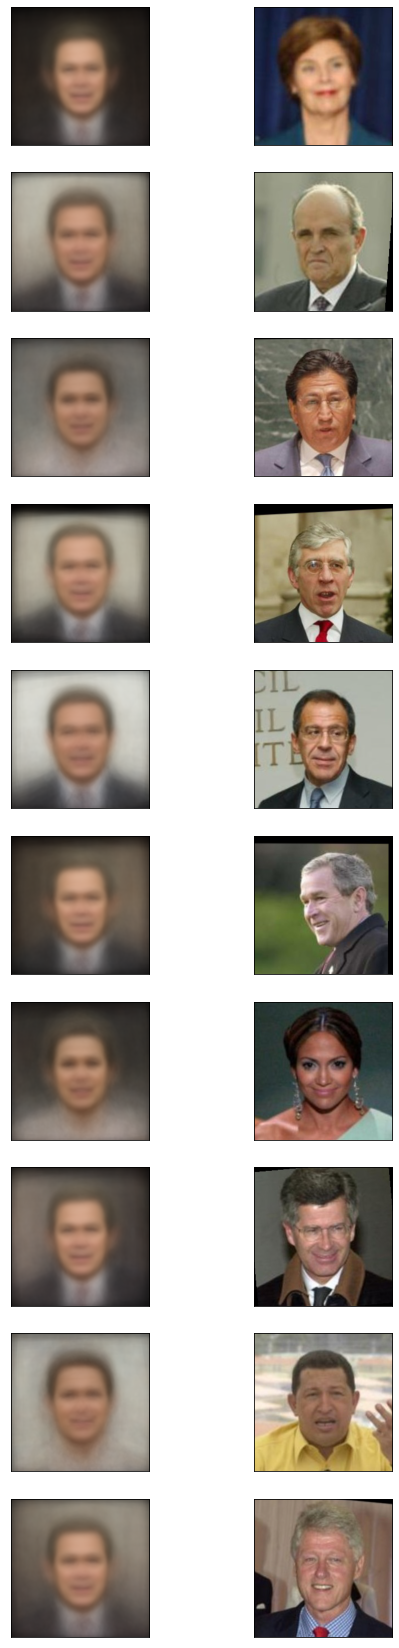

In [25]:
closest_neighbors = pairwise_distances_argmin(centroids, X, metric='euclidean')

fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(8,30))

for i in range(10):
    ax[i][0].imshow(centroids[i].reshape(250, 250,3))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])

    ax[i][1].imshow(X[closest_neighbors[i]].reshape(250,250,3))
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    
plt.show(fig)

The centroid for each cluster looks quite similar to the averaged face. And the people on the right hand side which represents the closest image in the original dataset to the centroid looks alike to the figure in the left hanb side.

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself.
 2. The cluster centroid closest to that image.
 3. The closest image in the dataset to that cluster centroid.
 4. The closest image in the dataset to the image of yourself.


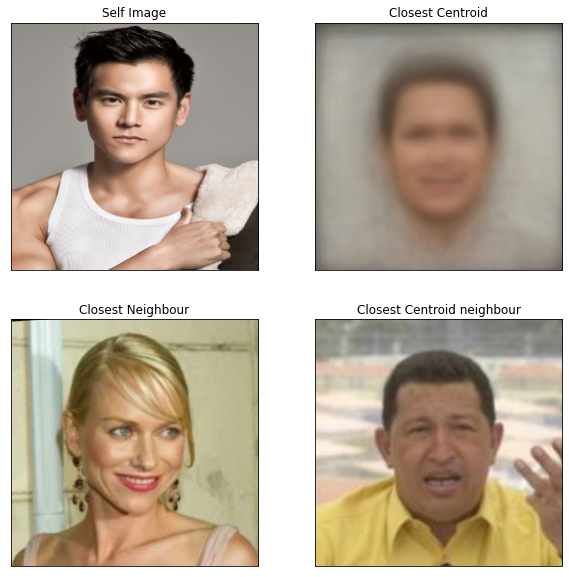

In [38]:
from skimage.transform import resize

peng = io.imread('Eddie_Peng.jpeg')
peng = resize(peng,(250,250,3))
peng = peng.reshape((1, 250*250*3))

closest_centroid = pairwise_distances_argmin(peng, centroids, metric='euclidean')
closest_neighbor = pairwise_distances_argmin(peng, X, metric='euclidean')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()

ax[0].imshow(peng.reshape(250,250,3))
ax[0].set_title('Self Image')

ax[1].imshow(centroids[closest_centroid[0]].reshape(250,250,3))
ax[1].set_title('Closest Centroid')

ax[2].imshow(X[closest_neighbor[0]].reshape(250,250,3))
ax[2].set_title('Closest Neighbour')

ax[3].imshow(X[closest_neighbors[closest_centroid[0]]].reshape(250,250,3))
ax[3].set_title('Closest Centroid neighbour')

for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show(fig)

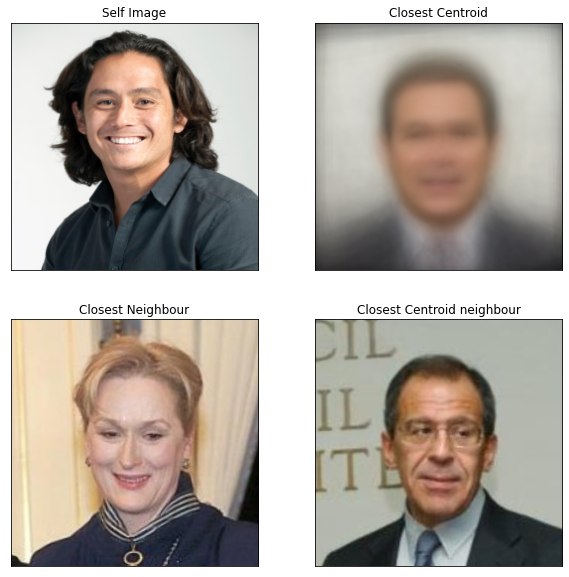

In [49]:
from skimage.transform import resize

peng = io.imread('joshua.jpeg')
peng = resize(peng,(250,250,3))
peng = peng.reshape((1, 250*250*3))

closest_centroid = pairwise_distances_argmin(peng, centroids, metric='euclidean')
closest_neighbor = pairwise_distances_argmin(peng, X, metric='euclidean')

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()

ax[0].imshow(peng.reshape(250,250,3))
ax[0].set_title('Self Image')

ax[1].imshow(centroids[closest_centroid[0]].reshape(250,250,3))
ax[1].set_title('Closest Centroid')

ax[2].imshow(X[closest_neighbor[0]].reshape(250,250,3))
ax[2].set_title('Closest Neighbour')

ax[3].imshow(X[closest_neighbors[closest_centroid[0]]].reshape(250,250,3))
ax[3].set_title('Closest Centroid neighbour')

for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show(fig)

### 2.5. (Extra credit): k-Means++
- In 2.1 you implemented k-Means clustering with random initialization of the centroids. In this part implement the k-Means++ version of the algorithm that uses a "smarter" initialization of the centroids in order to achieve faster convergence. Compare the number of iterations it took k-Means in 2.3 to converge with random initialization to the number of iterations it takes k-Means++. Also compare the sum of squared errors that you obtain for both methods. Use for both k=20 clusters. The following link shows the paper that proposed k-Means++.
http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf

In [ ]:
# Your code here

*Your comments here*

## 3. PCA and Eigenfaces 

Ensure you are using standardized data. Then, set aside 50% of the images as "test" data and using the remaining images as "training" data.


### 3.1. How many components?

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn on the training dataset. Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 100. How many components are required to explain 75% of the variation in your original data?

In [39]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

train, test = train_test_split(X, test_size=0.5, random_state=42)
print(train.shape, test.shape)

(2162, 187500) (2162, 187500)


In [41]:
pca = PCA(n_components = 0.75)
pca_features = pca.fit_transform(train)
pcs_number= pca_features.shape[1]
print("Number of PCs accounting for 75% of variance: ", pcs_number)

Number of PCs accounting for 75% of variance:  46


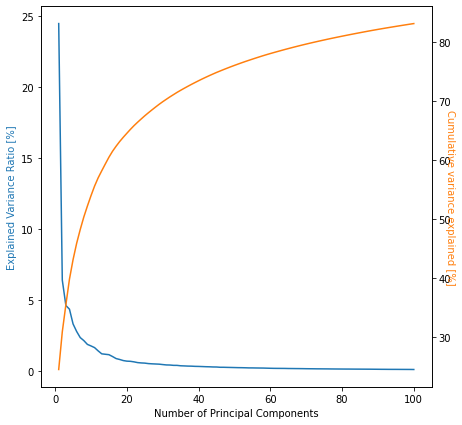

In [42]:
# Fitting PCA Model
pca = PCA(n_components=100)
pca.fit(train)

# Plot
fig, ax = plt.subplots(figsize=(7,7))

ax.plot(np.arange(len(pca.explained_variance_ratio_))+1,
        pca.explained_variance_ratio_*100, color='C0')
ax.set_ylabel('Explained Variance Ratio [%]', color='C0')
ax.set_xlabel('Number of Principal Components')

twinax = ax.twinx()
twinax.plot(np.arange(len(pca.explained_variance_ratio_))+1,
            np.cumsum(pca.explained_variance_ratio_)*100, color='C1')
twinax.set_ylabel('Cumulative variance explained [%]', rotation=270, color='C1')

plt.show(fig)

46 components are required to explain 75% of the variation in the original data

### 3.2. The Eigenfaces

Extract the 10 first principal components (the "eigenfaces") and display them below.

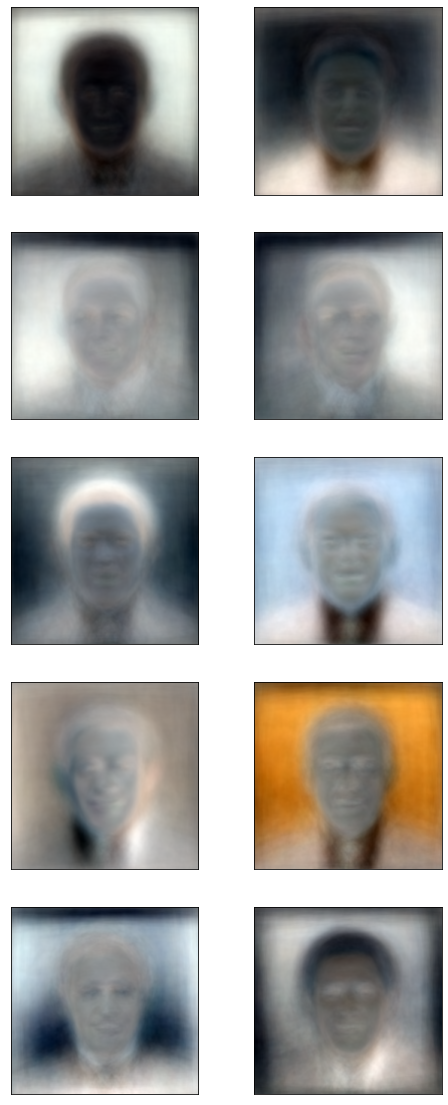

In [43]:
eg_10 = pca.components_[:10].copy()

for i in range(len(eg_10)):
    eg_10[i] = (eg_10[i] - np.min(eg_10[i])) / (np.max(eg_10[i]) - np.min(eg_10[i]))

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8,20))
ax = ax.flatten()

for i in range(len(eg_10)):
    ax[i].imshow(eg_10[i].reshape(250,250,3))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show(fig)

### 3.3. Projections, clustering and PCA
 - Project all of the training and test data into the 40-dimensional space defined by the first 40 principal components.
 - Apply k-means clustering, with k=16, to the 40-dimensional projections of the training data. 
 - Display a 4 x 4 grid of images that shows what each of the 16 centroids look like after the centroid is projected back into the original-image space.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


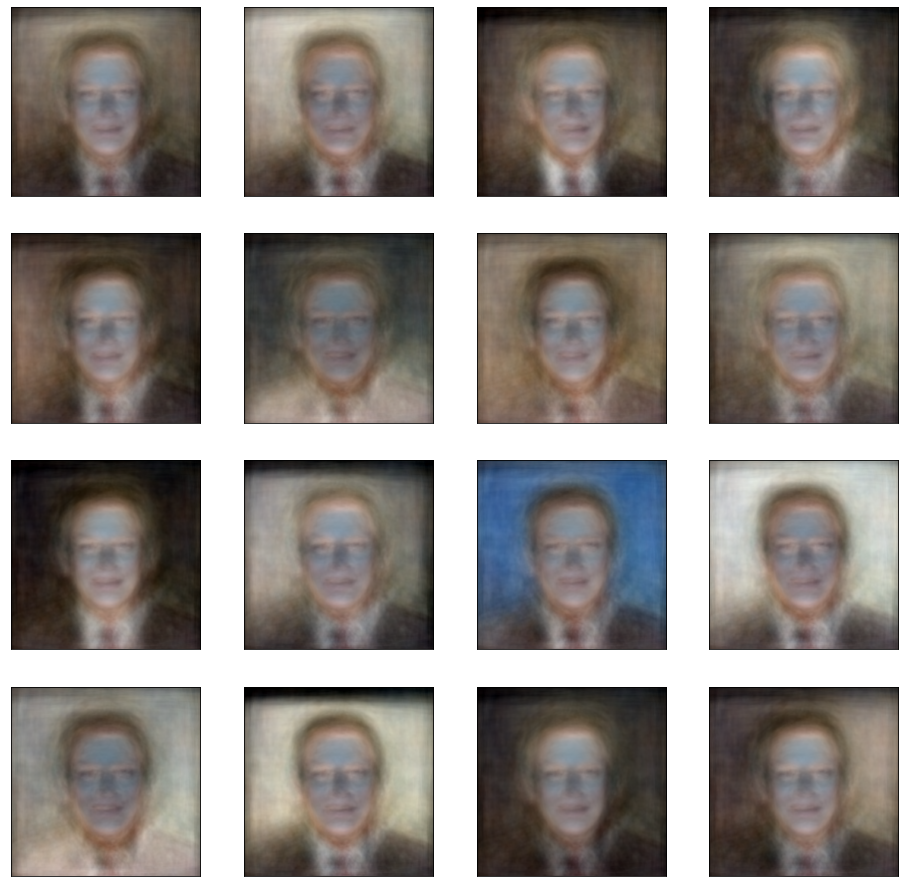

In [44]:
eg_40 = pca.components_[:40].copy()
train_40 = train.dot(eg_40.T)
test_40 = test.dot(eg_40.T)

# Apply K means Cluserting with 20 clusters
centroids_train_40, idx_train_40 = ClusterKM(train_40, 16)
centroids_train_40 = centroids_train_40.dot(eg_40)

# Plotting
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
ax = ax.flatten()

for i in range(16):
    ax[i].imshow(centroids_train_40[i].reshape(250, 250, 3))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show(fig)

### 3.4. (Extra Credit): Recognition

Create a set of 10 images using (i) 8 images randomly selected from the test data, (ii)  any other non-face image you can find that has the right dimensions, and (iii) an image of yourself. Create a 10 x 5 grid of images, with one row for each of these images, and 5 columns that contain: 
1. The original image. 
2. The reconstruction of that image after it is projected onto the 40-dimensional eigenface-space and then re-projected back into the original image space. 
3. Find the nearest centroid (from 3.3) to the image, and show the reconstruction of that nearest centroid. 
4. Find the image in the training data whose 40-dimensional representation is closest to that centroid, and show the reconstruction of that image.
5. Show the original training image that was selected in above (step 4 in this list)

Post the five images corresponding to your headshot on piazza to share with the rest of the class.

In [ ]:
# Your code here

# 4. Deep Learning

### 4.1 Data preprocessing
1. For this problem, filter to images associated with people that have at least 100 images in the dataset. Use the color version of the images (not grayscale). We'll use this dataset for a supervised multiclass classification problem, classifying which person each image is. How many classes (people) are there? How many observations (images) are there total?

2. Divide the reduced dataset into 50% train and 50% test. Standardize the data.

In [47]:
deep_images_df = n_images_df[n_images_df['ImageCount'] >= 100]
deep_images_df.reset_index(drop=True,inplace=True)
deep_images_df

,Name,ImageCount
0,Gerhard_Schroeder,109.0
1,Tony_Blair,144.0
2,Donald_Rumsfeld,121.0
3,Colin_Powell,236.0
4,George_W_Bush,530.0


In [53]:
deep_images_df['ImageCount'].sum()

1140.0

In [48]:
from PIL import Image

all_imgs = {}
for person in deep_images_df['Name']:
    all_imgs[person] = [img for img in os.listdir("lfw_funneled/"+person)]

all_data = []

for key, value in all_imgs.items():
    for img in value:
        image = Image.open('lfw_funneled/'+key+'/'+img) # read images from folders
        data = np.array(image) # convert to array shape of (250,250,3)
        all_data.append(data) # append data to list

In [50]:
df = pd.DataFrame()
df['Pictures'] = all_data

norm_df = df.copy()
norm_df["Pictures"] = norm_df["Pictures"].apply(normalizeImage)
X = np.stack(norm_df["Pictures"].values)

In [52]:
train, test= train_test_split(X,train_size = 0.5,random_state=123)
print(train.shape)
print(test.shape)

(570, 187500)
(570, 187500)


There are five people each of whom has more than 100 images. There are total 1140 images.

### 4.2 Naive baseline
As a naive baseline method to compare to, create a random ordering of the labels in the training set and the test set. Report the overall classification accuracy for the shuffled labels in comparison to the true labels. Also report the true positive rate for each class. This random baseline represents a naive classifier that guesses randomly among the classes. What do you notice about the differences in precision and recall across classes?

In [ ]:
# Your code here

*Your comments here*

### 4.3 Feed forward neural network
Reshape your X data so that each observation is flattened into a 1d array, and each of the training and test matrices are 2d arrays. The shape of your data should be n_observations X 187,500. Train a fully connected neural network to predict which class each observation is in. The input_dimensions of your network will be 187,500 for each of the 187,500 "features" obtained from the flattened images. You are responsible for determining the structure of the network, the activiation functions, regularization, and optmization techniques. Ensure that your network exceeds 70% overall classification accuracy on the test set. Report the classification accuracy on the test set, along with the precision and recall for each class. What do you notice about the precision and recall values, as well as the overall classification accuracy, in comparison to the naive baseline?

*Hint: If you're not sure where to start, consider revisiting labs 8 and 10.*

In [ ]:
# Your code here

*Your comments here*

### 4.4 Convolutional neural network

Now, train a convolutional neural network to predict which person is in each image. As above, you are in charge of all design parameters for the network, including convolutional filters, pooling layers, regularization, and optimization. Ensure that your CNN achieves over 80% overall classification accuracy on the test set. Report the classification accuracy on the test set, along with the precision and recall for each class. What do you notice about the precision and recall values, as well as the overall classification accuracy, in comparison to the feed forward neural network and naive baseline?

*Hint: If you're not sure where to start, consider revisiting lab 10.*

In [ ]:
# Your code here

*Your comments here*